# "Breast Cancer CT Scan dataset with fastai"
> "Basic vision model in the scope of Part 1 (2022) fastai Deep learning course"
- toc: false
- branch: master
- badges: true
- comments: true
- author: Sylvain Thibault
- categories: [fastai, part 1 2022, vision model]

Most of my experience with ML and Deep learning has been with tabular data and NLP.
Here is a basic vision model with the fastai library in the scope of Part 1 (2022) fastai Deep learning course.

I am using the Breast Cancer CT dataset from Kaggle to train a model https://www.kaggle.com/datasets/sabermalek/bcfpp
The dataset has 3 categorical labels:
- 0 : Cancer
- 1 : Benign
- 2 : Normal

In [1]:
#
#
# import libraries
import joblib as jlb
from fastai.vision.all import *

In [2]:
#
#
# Read data
images, labels, masks = jlb.load('../input/bcfpp/BCFPP.jlb')

# labels contains 3 classes (0 for Cancer, 1 for Benign and 2 for normal)

images = np.uint8(images)

# lets see what we got
print(f"images: {images.shape}")
print(f"labels: {labels.shape}")
print(f"masks: {masks.shape}")

images: (3600, 384, 256)
labels: (3600,)
masks: (3600, 384, 256)


#### We have 3600 Breast CT scans size 384 x 256 with labels and a mask

### Lets look at an image

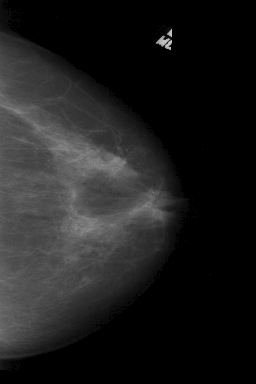

In [3]:
im = Image.fromarray(images[0])
im.to_thumb(384)

### And the corresponding mask

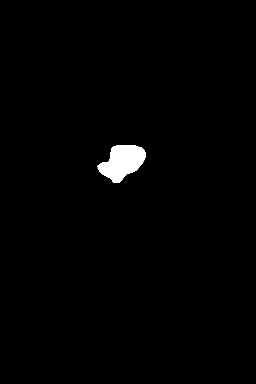

In [4]:
im = Image.fromarray(np.uint8(masks[0]))
im.to_thumb(384)

Not sure what to do with the mask data at this point so we will ignore it for now when training our model.

**Lets look at the distribution of our data labels to see if we are dealing with an unbalanced dataset.**

In [5]:
(pd.array(labels)
 .value_counts()
 .to_frame(name='labels')
 .set_axis(['count'], axis=1)
 .rename(index={0:'cancer',1:'benign',2:'normal'})
)

,count
cancer,1200
normal,1200
benign,1200


Perfectly balanced so no issue there.

### DataBlock
We have not covered DataBlock in depth yet and all the examples involve reading image files from disk.
The image data from the Breast CT scan dataset is in the form of a Numpy array.
We can use the DataBlock by defining functions for get_items, get_x and get_y.

Not the most elegant solution but at this stage it will get us to a model quickly.

I tried using lambda functions but I got and error with learn.export when I did that.

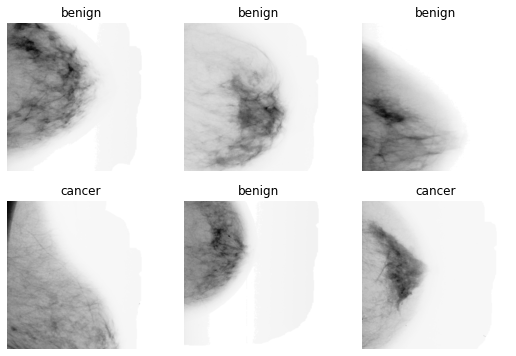

In [6]:
#
#
# just return the item index for items
def get_items(i):
    return i

# return image
def get_x(i):
    return images[i]

# return mapped label
def get_y(i):
    if labels[i] == 0: return "cancer"
    if labels[i] == 1: return "benign"
    if labels[i] == 2: return "normal"

#  Build DataBlock and keep 20% of our data for validation set
dls = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_items=get_items,
    get_x=get_x,
    get_y=get_y,
    item_tfms=Resize(384)
).dataloaders(list(range(images.shape[0])))

# look at a few images in our DataBlock
dls.show_batch(max_n=6)

In [7]:
# build a model from a resnet18
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.176696,1.136764,0.404167,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.713224,0.594963,0.272222,00:16
1,0.614766,0.535685,0.251389,00:15
2,0.540522,0.429647,0.209722,00:15
3,0.445284,0.406699,0.204167,00:15
4,0.368155,0.399672,0.181944,00:15
5,0.312639,0.393371,0.177778,00:15


In [8]:
# save model for deployment later
learn.export('model.pkl')

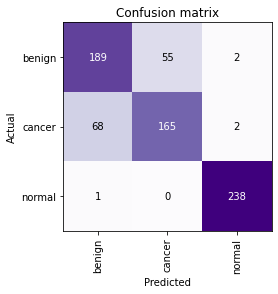

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(cmap='Purples')

In this classification we are looking to optimize cancer recall.  Misclassifying cancer for benign or benign for cancer is not an issue as a biopsy would most likely be performed to see if cancer is actually present.
So the bad outcome would be our model predicting a normal scan when it was actually cancer.

In our confusion matrix this was only the case for 2 scans !

In [10]:
print(f'percent of instances where model predicted normal when cancer was present: {round((2/len(dls.valid_ds))*100,2)}%')

percent of instances where model predicted normal when cancer was present: 0.28%


The model missed a cancer diagnosis in only 0.28% of the CT scans!  This is considering that the 68 times our model mislabelled cancer for benign it would have been caught with a biopsy.   